In [1]:
!git clone https://github.com/pwu-dev/deep-learning-project.git

Cloning into 'deep-learning-project'...
remote: Enumerating objects: 1862, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (389/389), done.
remote: Total 1862 (delta 28), reused 337 (delta 12), pack-reused 1461
Receiving objects: 100% (1862/1862), 941.18 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (250/250), done.
Updating files: 100% (1319/1319), done.


Fonction de chargement des images

In [2]:
import os
import PIL
from PIL import Image
import numpy as np

def load_data(data_path, classes, split="training", image_size=64):

	num_images = 0
	for i in range(len(classes)):
		dirs = sorted(os.listdir(data_path + '/' + split + '/' + classes[i]))
		num_images += len(dirs)
                                
	x = np.zeros((num_images, image_size, image_size, 3))
	y = np.zeros((num_images, 1))
    
	current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
	for idx_class in range(len(classes)):
		dirs = sorted(os.listdir(data_path + '/' + split + '/' + classes[idx_class]))
		num_images += len(dirs)
    
        # Chargement des images, 
		for idx_img in range(len(dirs)):
			item = dirs[idx_img]
			if os.path.isfile(data_path + '/' + split + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
				img = Image.open(data_path + '/' + split + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
				img = img.convert('RGB')

        # Redimensionnement de l'image et écriture dans la variable de retour x 
				img = img.resize((image_size,image_size))
				x[current_index] = np.asarray(img)/255
                # Écriture du label associé dans la variable de retour y
				y[current_index] = idx_class
				current_index += 1

	return x, y

Variables utiles

In [3]:
path = "./deep-learning-project/dataset"
CLASSES = ["beurre", "cremes-dessert", "eaux", "fromages", "haricots-verts", 
           "huiles-cuisson", "jus-fruits", "lait", "mais", "oeufs", 
           "pates", "petits-pois", "poissons", "riz", "sodas", 
           "soupes", "viandes-rouges", "volailles", "yaourts-laitiers"]

#CLASSES = ["oeufs", "lait", "eaux"]
IMAGE_SIZE = 128

Chargement des images

In [4]:
from sklearn.model_selection import train_test_split

x_total, y_total = load_data(path, CLASSES, split="entrainement", image_size=IMAGE_SIZE)

x_training, x_validation, y_training, y_validation = train_test_split(x_total, y_total, test_size=0.9, random_state=42)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


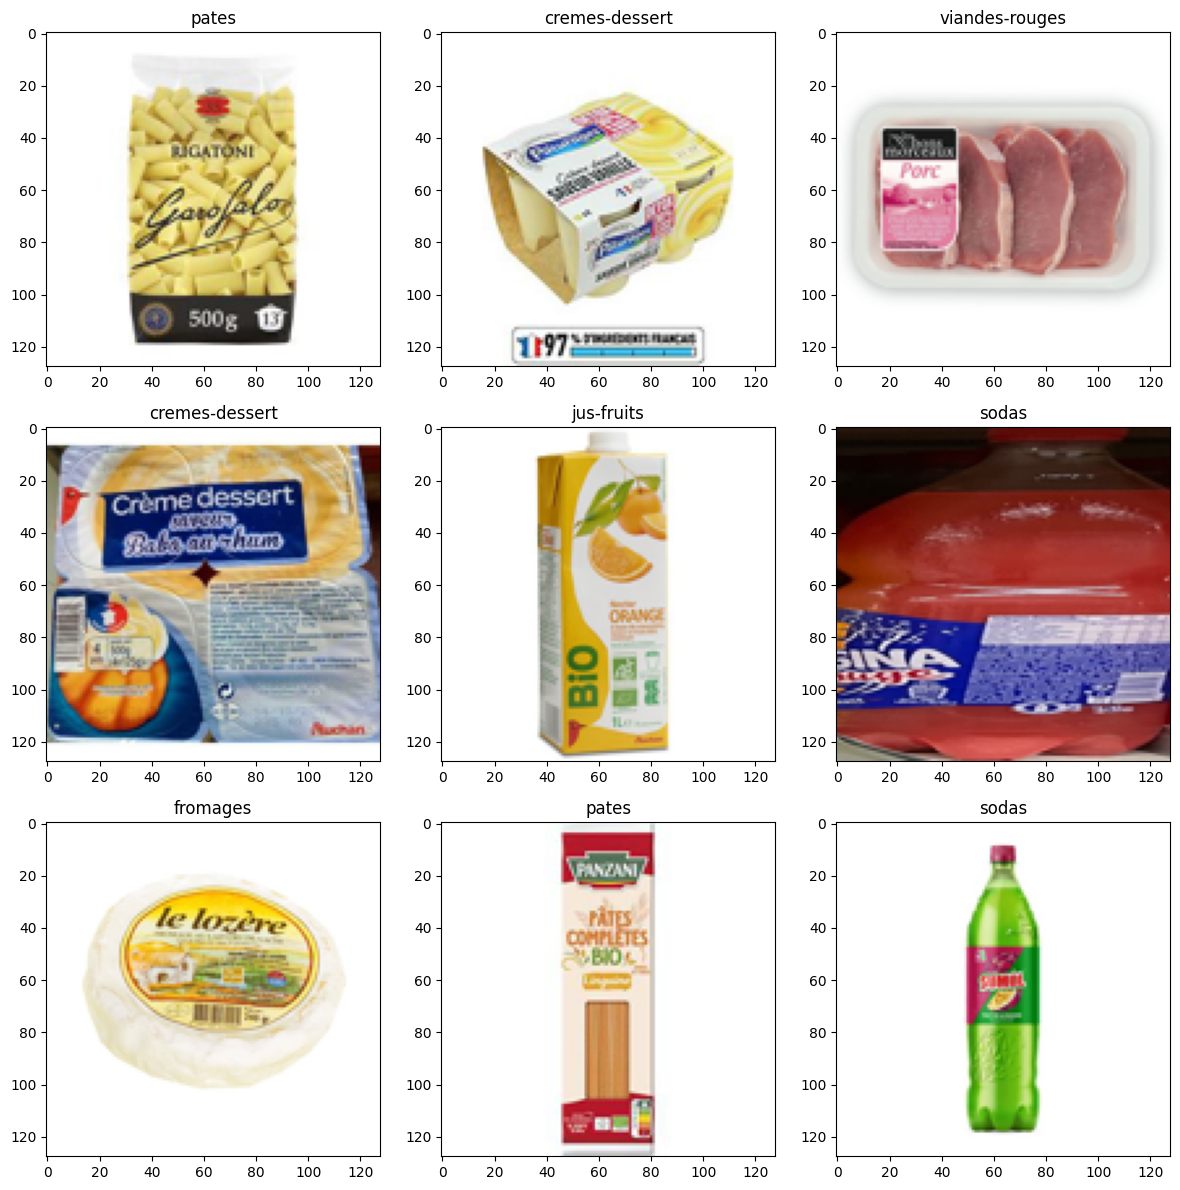

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(9)
for i in range(0, 9):
	plt.subplot(3, 3, i+1)
	image = x_validation[shuffle_indices[i]]
	plt.title(CLASSES[int(y_validation[shuffle_indices[i]])])
	plt.imshow(image)

plt.tight_layout()
plt.show()

In [7]:
%load_ext tensorboard

Création du model

In [12]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

HP_HIDDEN_LAYER = hp.HParam("hidden_layer", hp.Discrete([256, 512, 1024]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.1, 0.2))

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_HIDDEN_LAYER, HP_DROPOUT],
    metrics=[hp.Metric("sparse_categorical_accuracy", display_name="Accuracy")]
  )

def createModel(hparams, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    conv1 = tf.keras.layers.Conv2D(32, 3, activation="relu")(input_layer)
    dropout1 = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(conv1)
    pool1 = tf.keras.layers.MaxPooling2D()(dropout1)

    conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu")(pool1)
    dropout2 = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(conv2)
    pool2 = tf.keras.layers.MaxPooling2D()(dropout2)

    conv3 = tf.keras.layers.Conv2D(96, 3, activation="relu")(pool2)
    dropout3 = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(conv3)
    pool3 = tf.keras.layers.MaxPooling2D()(dropout3)

    conv4 = tf.keras.layers.Conv2D(128, 3, activation="relu")(pool3)
    dropout4 = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(conv4)
    pool4 = tf.keras.layers.MaxPooling2D()(dropout4)

    output = tf.keras.layers.Flatten()(pool4)
    output = tf.keras.layers.Dense(hparams[HP_HIDDEN_LAYER], activation="relu")(output)
    output = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(output)
    output = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(output)

    model = tf.keras.models.Model(input_layer, output)

    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"],
    )

    return model


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    model = createModel(hparams)
    model.fit(x_training, y_training, 
              validation_data=(x_validation, y_validation), 
              epochs=10, 
              batch_size=10
              )
    _, accuracy = model.evaluate(x_validation, y_validation)
    tf.summary.scalar("sparse_categorical_accuracy", accuracy, step=1)

In [13]:
import tensorflow as tf

session_num = 0

for num_units in HP_HIDDEN_LAYER.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    hparams = {
        HP_HIDDEN_LAYER: num_units,
        HP_DROPOUT: dropout_rate
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1

--- Starting trial: run-0
{'hidden_layer': 256, 'dropout': 0.1}
Epoch 1/10
14/14 [==============================] - 4s 120ms/step - loss: 2.9071 - sparse_categorical_accuracy: 0.0840 - val_loss: 2.8512 - val_sparse_categorical_accuracy: 0.1008
Epoch 2/10
14/14 [==============================] - 0s 35ms/step - loss: 2.8165 - sparse_categorical_accuracy: 0.0916 - val_loss: 2.8251 - val_sparse_categorical_accuracy: 0.0975
Epoch 3/10
14/14 [==============================] - 0s 35ms/step - loss: 2.7097 - sparse_categorical_accuracy: 0.1298 - val_loss: 2.7648 - val_sparse_categorical_accuracy: 0.1110
Epoch 4/10
14/14 [==============================] - 0s 34ms/step - loss: 2.6391 - sparse_categorical_accuracy: 0.1603 - val_loss: 2.7172 - val_sparse_categorical_accuracy: 0.1915
Epoch 5/10
14/14 [==============================] - 1s 61ms/step - loss: 2.4678 - sparse_categorical_accuracy: 0.2214 - val_loss: 2.6508 - val_sparse_categorical_accuracy: 0.1839
Epoch 6/10
14/14 [======================

In [ ]:
%tensorboard --logdir logs/hparam_tuning

Entrainement du réseau

In [ ]:
history = model.fit(x_training, y_training, validation_data=(x_validation, y_validation), epochs=10, batch_size=10)

In [ ]:
import matplotlib.pyplot as plt

def plot_training_analysis():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

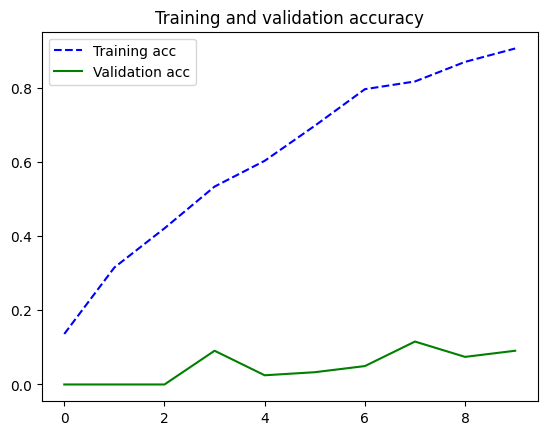

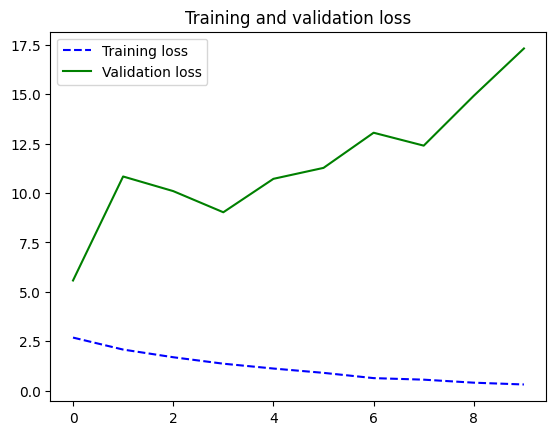

In [ ]:
plot_training_analysis()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


In [ ]:
import tensorflow as tf

model = createModel()
model.summary()

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              metrics=["sparse_categorical_accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 96)        55392     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 96)      

Epoch 1/50
2/2 [==============================] - 3s 266ms/step - loss: 1.1540 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.3820 - val_sparse_categorical_accuracy: 0.2955
Epoch 2/50
2/2 [==============================] - 0s 107ms/step - loss: 1.0204 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.3006 - val_sparse_categorical_accuracy: 0.3409
Epoch 3/50
2/2 [==============================] - 0s 99ms/step - loss: 1.0168 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.3062 - val_sparse_categorical_accuracy: 0.3409
Epoch 4/50
2/2 [==============================] - 0s 98ms/step - loss: 1.0186 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.3375 - val_sparse_categorical_accuracy: 0.3409
Epoch 5/50
2/2 [==============================] - 0s 81ms/step - loss: 1.0013 - sparse_categorical_accuracy: 0.4286 - val_loss: 1.3711 - val_sparse_categorical_accuracy: 0.4394
Epoch 6/50
2/2 [==============================] - 0s 73ms/step - loss: 1.0004 - sparse_categorical_accuracy: 0.64

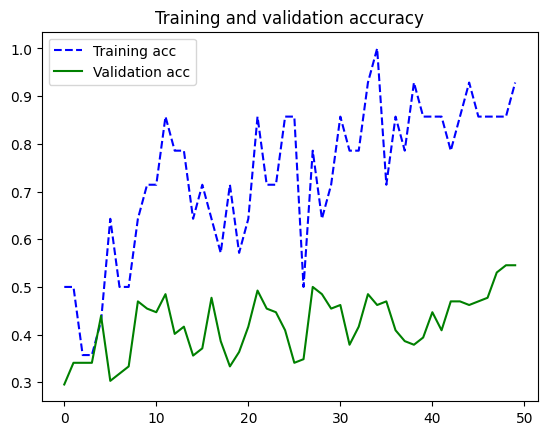

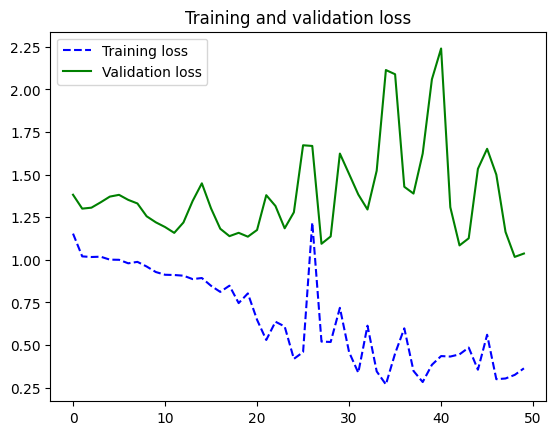

In [ ]:
history = model.fit(train_datagen.flow(x_training, y_training, batch_size=10), validation_data=(x_validation, y_validation), epochs=50)
plot_training_analysis()

In [ ]:
print(history.history)

{'loss': [1.1304851770401, 1.0064687728881836, 1.0083441734313965, 1.0220731496810913, 1.0054733753204346, 0.9713283777236938, 0.9726852774620056, 0.9546376466751099, 0.9386817812919617, 0.9285985231399536, 0.8450208306312561, 0.8231967091560364, 0.8576037287712097, 0.7919977903366089, 0.7658685445785522, 0.6721805930137634, 0.7437207102775574, 0.5552645921707153, 0.5640741586685181, 0.6817087531089783, 0.5846776366233826, 0.4832247197628021, 0.68328857421875, 0.5967288613319397, 0.6047893762588501, 0.48047956824302673, 0.8687686920166016, 0.3534843623638153, 0.6952534914016724, 0.7543271780014038, 0.8541693687438965, 0.6576238870620728, 0.5419583916664124, 0.37769952416419983, 0.4994850158691406, 0.5911742448806763, 0.4805266559123993, 0.3498390018939972, 0.5753189921379089, 0.4090110659599304, 0.5164234042167664, 0.41477492451667786, 0.35352596640586853, 0.39590954780578613, 0.5571498274803162, 0.2584454417228699, 0.25074613094329834, 0.3955082297325134, 0.4479421079158783, 0.2613001

Transfert Learning


In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

conv_base.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
model = tf.keras.models.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(len(CLASSES), activation='softmax'))

conv_base.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_training, y_training, batch_size=10), 
                    validation_data=(x_validation, y_validation),
                    epochs=100,
                    )

Epoch 1/100
2/2 [==============================] - 7s 4s/step - loss: 1.3218 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.7090 - val_sparse_categorical_accuracy: 0.2955
Epoch 2/100
2/2 [==============================] - 0s 309ms/step - loss: 1.0034 - sparse_categorical_accuracy: 0.5714 - val_loss: 1.4527 - val_sparse_categorical_accuracy: 0.4773
Epoch 3/100
2/2 [==============================] - 0s 337ms/step - loss: 0.5869 - sparse_categorical_accuracy: 0.7143 - val_loss: 1.3703 - val_sparse_categorical_accuracy: 0.5076
Epoch 4/100
2/2 [==============================] - 0s 376ms/step - loss: 0.4528 - sparse_categorical_accuracy: 0.7857 - val_loss: 1.0967 - val_sparse_categorical_accuracy: 0.5227
Epoch 5/100
2/2 [==============================] - 0s 366ms/step - loss: 0.3978 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.7175 - val_sparse_categorical_accuracy: 0.6894
Epoch 6/100
2/2 [==============================] - 0s 207ms/step - loss: 0.2720 - sparse_categorical_accurac

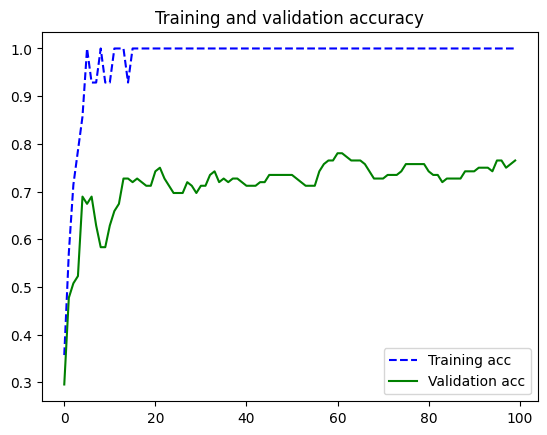

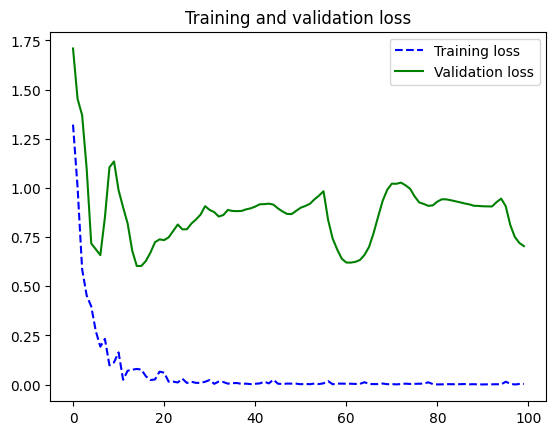

In [ ]:
plot_training_analysis()

2/2 [==============================] - 2s 2s/step


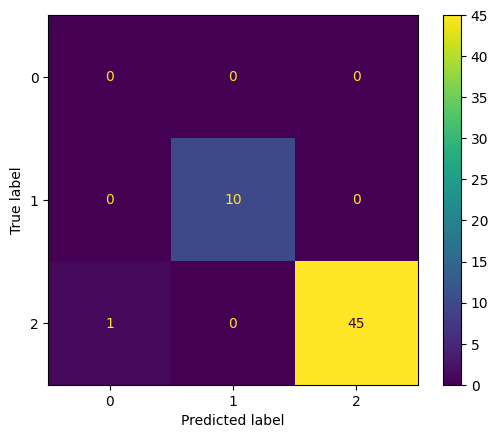

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = np.argmax(model.predict(x_validation), axis=-1)
cm = confusion_matrix(y_validation, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

fig, ax = plt.subplots(figsize=(25,25))
disp.plot(ax=ax)
plt.show()